# SEMANTIC SEGMENTATION USING FEATURE LEVEL FUSION FOR THE YEAR 2019

# 1. VISUALIZE THE SATELLITE DATA ALONG WITH RASTERIZED GROUND TRUTH 

In [1]:
# MOUNT GOOGLE DRIVE
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# IMPORT ESSENTIAL LIBRARIES
import os
import numpy as np
import gdal
import keras
import tensorflow as tf
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 10)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage import exposure
from google.colab import drive

Populating the interactive namespace from numpy and matplotlib


In [3]:
# DEFINING A FUNCTION WHICH TAKES A "file_path" AND RETURNS A "tif" FILE AS A 3-DIMENSIONAL NUMPY ARRAY AS: WIDTH X HEIGHT X BANDS
def gtiff_to_array(file_path):
    data = gdal.Open(file_path)
    bands = [data.GetRasterBand(i+1).ReadAsArray() for i in range(data.RasterCount)]
    return np.stack(bands, axis = 2)

In [4]:
# DEFINING A FUNCTION TO FETCH THE IMAGE ARRAY INFORMATION FOR VISUALIZATION
def fetch_tiles(path):
    tiles = {}
    for f in path:
      _, ext = os.path.splitext(f)
      if ext.lower() == ".tif":
        imgtype = f[-7:-4]
        tiles[imgtype] = gtiff_to_array(f)
    return tiles

In [5]:
# DEFINING A FUNCTION TO VISUALIZE THE LABELS PREPARED FROM THE REFERENCE IMAGES
def visualize_labels(labels, fig_width = 5, fig_height = 5):
    fig = plt.figure(figsize = (fig_width, fig_height))
    a = fig.add_subplot(1, 1, 1)
    values = np.unique(labels.ravel())
    im = plt.imshow(labels[:, :, 0])
    a.set_title("GROUND TRUTH")
    # get the colors of the values, according to the 
    # colormap used by imshow
    colors = [im.cmap(im.norm(value)) for value in values]
    # create a patch (proxy artist) for every color 
    labels = ["DEFORESTATION", "NON-DEFORESTATION"]
    patches = [mpatches.Patch(color = colors[i], label = j) for i, j in zip(range(len(values)), labels)]
    # put those patched as legend-handles into the legend
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [6]:
# DEFINING A FUNCTION TO VISUALIZE THE SATELLITE IMAGE DATA
def visualize_data(data, title, fig_width = 5, fig_height = 5):
    # Visualize only RGB Bands
    data = data[:, :, 0:-1]
    # data = data[:, :, 0]
    _ = data[:, :, 0].copy()
    data[:, :, 0] = data[:, :, 2]
    data[:, :, 2] = _
    data = data.astype(np.float)
    
    # Perform Stretching for Better Visualization
    for i in range(data.shape[2]):
        p2, p98 = np.percentile(data[:, :, i], (2, 98))
        data[:, :, i] = exposure.rescale_intensity(data[:, :, i],
                                                      in_range=(p2, p98))
    fig = plt.figure(figsize = (fig_width, fig_height))
    a = fig.add_subplot(1,1,1)
    a.set_title(title)
    plt.imshow(data)

# OPENING SENTINEL-1 AND SENTINEL-2 FULL IMAGE TO TEST THE MODEL 

In [7]:
# PUTTING ALL THE "IMAGES" AND "LABELS" INSIDE VARIABLES "image_path" AND "mask_path"
image_path_full_S1 = "/content/drive/MyDrive/MASTER_RESEARCH/MODEL_TESTING/2_DEFORESTATION/AKHIL_MODEL/CLOUD_FREE_DATASET/2020/SENTINEL1/IMAGE_FULL/"
image_path_full_S2 = "/content/drive/MyDrive/MASTER_RESEARCH/MODEL_TESTING/2_DEFORESTATION/AKHIL_MODEL/CLOUD_FREE_DATASET/2020/SENTINEL2/IMAGE_FULL/"
mask_path_full = "/content/drive/MyDrive/MASTER_RESEARCH/MODEL_TESTING/2_DEFORESTATION/AKHIL_MODEL/MASK_2020/MASK_FULL/"

# GETTING THE NAMES OF IMAGES AND MASKS
image_list_full_S1 = os.listdir(image_path_full_S1)
image_list_full_S2 = os.listdir(image_path_full_S2)
mask_list_full = os.listdir(mask_path_full)

# SORTING THE NAMES OF IMAGES AND MASKS IN ASCENDING NUMBER ORDER 
image_list_full_S1.sort()
image_list_full_S2.sort()
mask_list_full.sort()

# CONCATENATING THE DIRECTORY WITH THE SPECIFIC IMAGE NAME AND EXTENSION
image_list_full_S1 = [image_path_full_S1 + i for i in image_list_full_S1]
image_list_full_S2 = [image_path_full_S2 + i for i in image_list_full_S2]
mask_list_full = [mask_path_full + i for i in mask_list_full]

In [8]:
# PRINTING DIRECTORY OF ALL THE "IMAGES" AND "LABELS"
print("SENTINEL-1 IMAGES:", image_list_full_S1)
print("SENTINEL-2 IMAGES:", image_list_full_S2)
print("LABELS:", mask_list_full)

SENTINEL-1 IMAGES: ['/content/drive/MyDrive/MASTER_RESEARCH/MODEL_TESTING/2_DEFORESTATION/AKHIL_MODEL/CLOUD_FREE_DATASET/2020/SENTINEL1/IMAGE_FULL/raster.tif']
SENTINEL-2 IMAGES: ['/content/drive/MyDrive/MASTER_RESEARCH/MODEL_TESTING/2_DEFORESTATION/AKHIL_MODEL/CLOUD_FREE_DATASET/2020/SENTINEL2/IMAGE_FULL/raster.tif']
LABELS: ['/content/drive/MyDrive/MASTER_RESEARCH/MODEL_TESTING/2_DEFORESTATION/AKHIL_MODEL/MASK_2020/MASK_FULL/raster.tif']


In [9]:
# FETCH ALL THE ARRAY INFORMATION WITHIN THE VARIABLE "image_tiles" AND "label_tiles" FOR VISUALIZATION
image_tiles_full_S1 = fetch_tiles(image_list_full_S1)
image_tiles_full_S2 = fetch_tiles(image_list_full_S2)
label_tiles_full = fetch_tiles(mask_list_full)

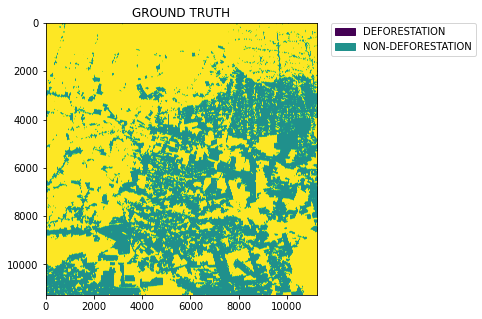

In [10]:
# IF YOU WANT TO VISUALIZE AN IMAGE AND LABEL BETWEEN 0 TO 9, RIGHT AN UNDERSCORE BEFORE IT E.G. "R_0" INSTEAD OF 0 OR "R_9" INSTEAD OF 9
# IF YOU WANT TO VISUALIZE AN IMAGE AND LABEL BETWEEN 10 TO 99, RIGHT AN UNDERSCORE BEFORE IT E.G. "_10" INSTEAD OF 10 OR "_90" INSTEAD OF 90
# IF YOU WANT TO VISUALIZE AN IMAGE AND LABEL BETWEEN 100 TO 143, RIGHT IT AS IT IS I.E. "100" FOR 1O0 OR "119" FOR "119"
image_number_full = "ter"
# visualize_data(image_tiles_full_S1[image_number_full], "INPUT IMAGE")
# visualize_data(image_tiles_full_S2[image_number_full], "INPUT IMAGE")
visualize_labels(label_tiles_full[image_number_full])

# OPENING SENTINEL-1 AND SENTINEL-2 16 GRID IMAGE TO TEST THE MODEL 

In [11]:
# PUTTING ALL THE "IMAGES" AND "LABELS" INSIDE VARIABLES "image_path" AND "mask_path"
image_path_S1_16_grid = "/content/drive/MyDrive/MASTER_RESEARCH/MODEL_TESTING/2_DEFORESTATION/AKHIL_MODEL/CLOUD_FREE_DATASET/2020/SENTINEL1/IMAGE_16_GRID/"
image_path_S2_16_grid = "/content/drive/MyDrive/MASTER_RESEARCH/MODEL_TESTING/2_DEFORESTATION/AKHIL_MODEL/CLOUD_FREE_DATASET/2020/SENTINEL2/IMAGE_16_GRID/"
mask_path_16_grid = "/content/drive/MyDrive/MASTER_RESEARCH/MODEL_TESTING/2_DEFORESTATION/AKHIL_MODEL/MASK_2020/MASK_16_GRID/"

# GETTING THE NAMES OF IMAGES AND MASKS
image_list_S1_16_grid = os.listdir(image_path_S1_16_grid)
image_list_S2_16_grid = os.listdir(image_path_S2_16_grid)
mask_list_16_grid = os.listdir(mask_path_16_grid)

# SORTING THE NAMES OF IMAGES AND MASKS IN ASCENDING NUMBER ORDER 
image_list_S1_16_grid.sort()
image_list_S2_16_grid.sort()
mask_list_16_grid.sort()

# CONCATENATING THE DIRECTORY WITH THE SPECIFIC IMAGE NAME AND EXTENSION
image_list_S1_16_grid = [image_path_S1_16_grid + i for i in image_list_S1_16_grid]
image_list_S2_16_grid = [image_path_S2_16_grid + i for i in image_list_S2_16_grid]
mask_list_16_grid = [mask_path_16_grid + i for i in mask_list_16_grid]

In [12]:
# PRINTING DIRECTORY OF ALL THE "IMAGES" AND "LABELS"
print("SENTINEL-1 IMAGES:", image_list_S1_16_grid)
print("SENTINEL-2 IMAGES:", image_list_S2_16_grid)
print("LABELS:", mask_list_16_grid)

SENTINEL-1 IMAGES: ['/content/drive/MyDrive/MASTER_RESEARCH/MODEL_TESTING/2_DEFORESTATION/AKHIL_MODEL/CLOUD_FREE_DATASET/2020/SENTINEL1/IMAGE_16_GRID/RASTER_0.tif', '/content/drive/MyDrive/MASTER_RESEARCH/MODEL_TESTING/2_DEFORESTATION/AKHIL_MODEL/CLOUD_FREE_DATASET/2020/SENTINEL1/IMAGE_16_GRID/RASTER_1.tif', '/content/drive/MyDrive/MASTER_RESEARCH/MODEL_TESTING/2_DEFORESTATION/AKHIL_MODEL/CLOUD_FREE_DATASET/2020/SENTINEL1/IMAGE_16_GRID/RASTER_10.tif', '/content/drive/MyDrive/MASTER_RESEARCH/MODEL_TESTING/2_DEFORESTATION/AKHIL_MODEL/CLOUD_FREE_DATASET/2020/SENTINEL1/IMAGE_16_GRID/RASTER_11.tif', '/content/drive/MyDrive/MASTER_RESEARCH/MODEL_TESTING/2_DEFORESTATION/AKHIL_MODEL/CLOUD_FREE_DATASET/2020/SENTINEL1/IMAGE_16_GRID/RASTER_12.tif', '/content/drive/MyDrive/MASTER_RESEARCH/MODEL_TESTING/2_DEFORESTATION/AKHIL_MODEL/CLOUD_FREE_DATASET/2020/SENTINEL1/IMAGE_16_GRID/RASTER_13.tif', '/content/drive/MyDrive/MASTER_RESEARCH/MODEL_TESTING/2_DEFORESTATION/AKHIL_MODEL/CLOUD_FREE_DATASET/2020/

In [13]:
# FETCH ALL THE ARRAY INFORMATION WITHIN THE VARIABLE "image_tiles" AND "label_tiles" FOR VISUALIZATION
image_tiles_S1_16_grid = fetch_tiles(image_list_S1_16_grid)
image_tiles_S2_16_grid = fetch_tiles(image_list_S2_16_grid)
label_tiles_16_grid = fetch_tiles(mask_list_16_grid)

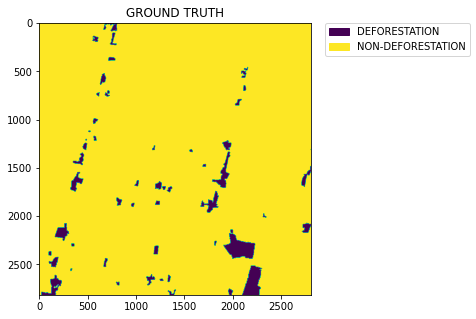

In [14]:
# IF YOU WANT TO VISUALIZE AN IMAGE AND LABEL BETWEEN 0 TO 9, RIGHT AN UNDERSCORE BEFORE IT E.G. "R_0" INSTEAD OF 0 OR "R_9" INSTEAD OF 9
# IF YOU WANT TO VISUALIZE AN IMAGE AND LABEL BETWEEN 10 TO 99, RIGHT AN UNDERSCORE BEFORE IT E.G. "_10" INSTEAD OF 10 OR "_90" INSTEAD OF 90
# IF YOU WANT TO VISUALIZE AN IMAGE AND LABEL BETWEEN 100 TO 143, RIGHT IT AS IT IS I.E. "100" FOR 1O0 OR "119" FOR "119"
image_number_16_grid = "R_0"
# visualize_data(image_tiles_S1_16_grid[image_number_16_grid], "INPUT IMAGE")
# visualize_data(image_tiles_S2_16_grid[image_number_16_grid], "INPUT IMAGE")
visualize_labels(label_tiles_16_grid[image_number_16_grid])

# 3. SPLITTING THE TILES IN THE FORM OF PATCHES IN A GRID WISE MANNER 

# FULL IMAGE

In [15]:
# SETTING UP THE PATCH SIZE AND IDENTIFICATION OF THE NUMBER OF BANDS
patch_size = 256
nband_S1 = image_tiles_full_S1["ter"].shape[-1]
nband_S2 = image_tiles_full_S2["ter"].shape[-1]
print("NUMBER OF BANDS IN SENTINEL-1 RASTER:", nband_S1)
print("NUMBER OF BANDS IN SENTINEL-2 RASTER:", nband_S2)

NUMBER OF BANDS IN SENTINEL-1 RASTER: 2
NUMBER OF BANDS IN SENTINEL-2 RASTER: 4


In [16]:
# DEFINING A FUNCTION FOR CONVERTING IMAGES AND LABELS INTO PATCHES OF 256 x 256
def gridwise_sample(imgarray, patchsize):
    nrows, ncols, nbands = imgarray.shape
    patchsamples = np.zeros(shape = (0, patchsize, patchsize, nbands),
                            dtype = imgarray.dtype)
    for i in range(int(nrows/patchsize)):
        for j in range(int(ncols/patchsize)):
            tocat = imgarray[i * patchsize:(i + 1)*patchsize,
                             j * patchsize:(j + 1)*patchsize, :]
            tocat = np.nan_to_num(tocat, nan = np.nanmedian(tocat))
            tocat[tocat < -1] = np.median(tocat)
            tocat = np.expand_dims(tocat, axis = 0)
            patchsamples = np.concatenate((patchsamples, tocat),axis=0)
    return patchsamples

In [17]:
# SETTING UP FULL IMAGE FOR SENTINEL-1 AND SENTINEL-2 DATASET
Xtrain_full_S1 = np.zeros(shape = (0, patch_size, patch_size, nband_S1), dtype = np.float32)
Xtrain_full_S2 = np.zeros(shape = (0, patch_size, patch_size, nband_S2), dtype = np.float32)
Ytrain_full = np.zeros(shape = (0, patch_size, patch_size, 1), dtype = np.uint8)

# Sample of each Training Tile Systematically in a Gridwise Manner
train_areas_full = ["ter"]

for area in train_areas_full:
    X_toadd_full_S1 = gridwise_sample(image_tiles_full_S1[area], patch_size)
    X_toadd_full_S2 = gridwise_sample(image_tiles_full_S2[area], patch_size)
    Y_toadd_full = gridwise_sample(label_tiles_full[area], patch_size)
    Xtrain_full_S1 = np.concatenate((Xtrain_full_S1, X_toadd_full_S1), axis = 0)
    Xtrain_full_S2 = np.concatenate((Xtrain_full_S2, X_toadd_full_S2), axis = 0)
    Ytrain_full = np.concatenate((Ytrain_full, Y_toadd_full), axis = 0)

# Encode all Non-Deforestation Classes as Class "2"
Ytrain_full[Ytrain_full!=1] = 2
print("There are %i Training Patches in Sentinel-1 Raster of Size 256 x 256" % (Xtrain_full_S1.shape[0]))
print("There are %i Training Patches in Sentinel-2 Raster of Size 256 x 256" % (Xtrain_full_S2.shape[0]))

There are 1936 Training Patches in Sentinel-1 Raster of Size 256 x 256
There are 1936 Training Patches in Sentinel-2 Raster of Size 256 x 256


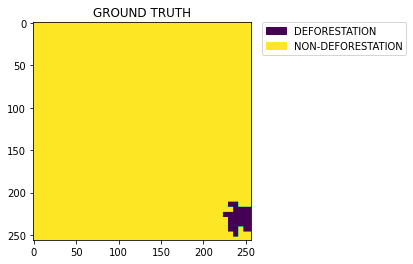

In [18]:
# VISUALIZING ONE RANDOM 256 x 256 PATCH I.E. IMAGE AGAINST ITS LABEL
patch_number_full = 451
# visualize_data(Xtrain_full_S1[patch_number_full], "Training Patch " + str(patch_number_full), 4, 4)
# visualize_data(Xtrain_full_S2[patch_number_full], "Training Patch " + str(patch_number_full), 4, 4)
visualize_labels(Ytrain_full[patch_number_full], 4, 4)

# IMAGE DIVIDED INTO 16 GRID

In [19]:
# SETTING UP THE PATCH SIZE AND IDENTIFICATION OF THE NUMBER OF BANDS
nband_S1_16_grid = image_tiles_S1_16_grid["R_0"].shape[-1]
nband_S2_16_grid = image_tiles_S2_16_grid["R_0"].shape[-1]
print("NUMBER OF BANDS IN SENTINEL-1 RASTER:", nband_S1_16_grid)
print("NUMBER OF BANDS IN SENTINEL-2 RASTER:", nband_S2_16_grid)

NUMBER OF BANDS IN SENTINEL-1 RASTER: 2
NUMBER OF BANDS IN SENTINEL-2 RASTER: 4


In [20]:
# SETTING UP FULL IMAGE FOR SENTINEL-1 AND SENTINEL-2 DATASET
Xtrain_S1_16_grid = np.zeros(shape = (0, patch_size, patch_size, nband_S1_16_grid), dtype = np.float32)
Xtrain_S2_16_grid = np.zeros(shape = (0, patch_size, patch_size, nband_S2_16_grid), dtype = np.float32)
Ytrain_16_grid = np.zeros(shape = (0, patch_size, patch_size, 1), dtype = np.uint8)

# Sample of each Training Tile Systematically in a Gridwise Manner
train_areas_16_grid = ["R_0", "R_1", "R_2", "R_3" ,"R_4", "R_5", "R_6", "R_7", "R_8", "R_9", 
                       "_10", "_11", "_13", "_15" ,] # "_12" AND "_14" ARE KEPT FOR TEST SET 
                       
for area in train_areas_16_grid:
    X_toadd_S1_16_grid = gridwise_sample(image_tiles_S1_16_grid[area], patch_size)
    X_toadd_S2_16_grid = gridwise_sample(image_tiles_S2_16_grid[area], patch_size)
    Y_toadd_16_grid = gridwise_sample(label_tiles_16_grid[area], patch_size)
    Xtrain_S1_16_grid = np.concatenate((Xtrain_S1_16_grid, X_toadd_S1_16_grid), axis = 0)
    Xtrain_S2_16_grid = np.concatenate((Xtrain_S2_16_grid, X_toadd_S2_16_grid), axis = 0)
    Ytrain_16_grid = np.concatenate((Ytrain_16_grid, Y_toadd_16_grid), axis = 0)

# Encode all Non-Deforestation Classes as Class "2"
Ytrain_16_grid[Ytrain_16_grid!=1] = 2
print("There are %i Training Patches in Sentinel-1 Raster of Size 256 x 256" % (Xtrain_S1_16_grid.shape[0]))
print("There are %i Training Patches in Sentinel-2 Raster of Size 256 x 256" % (Xtrain_S2_16_grid.shape[0]))

There are 1694 Training Patches in Sentinel-1 Raster of Size 256 x 256
There are 1694 Training Patches in Sentinel-2 Raster of Size 256 x 256


# 5. SETTING UP THE FULLY CONVOLUTIONAL NETWRK (FCN)

In [21]:
# IMPORTING THE ESSENTIAL LIBRARIES
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Activation, BatchNormalization, Reshape
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD, Adadelta
import tensorflow.python.keras.backend as K
sess = K.get_session()
from tensorflow.compat.v1.keras.backend import set_session

In [22]:
# IMPORTING THE ESSENTIAL LIBRARIES FOR UNET
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

In [23]:
# DEFINING A FUNCTION FOR CONVERTING GROUND TRUTH TO ONE-HOT ENCODING
def to_categorical_4d(y, nc):
    Y = np.zeros((y.shape[0],
                  y.shape[1],
                  y.shape[2],
                  nc),
                  dtype=np.int32)
    for h in range(y.shape[0]):
        for i in range(y.shape[1]):
            for j in range(y.shape[2]):
                if y[h, i, j, 0]!= 0:
                    Y[h, i, j, y[h, i, j, 0]-1] = 1
                else:
                    continue
    return Y

In [24]:
# TRANSFORM TARGET ARRAYS TO ONE-HOT ENCODINGS
Ytrain_16_grid = to_categorical_4d(Ytrain_16_grid, 2)

# 6. DEFINING A FUNCTION FOR LATE FUSION BASED ON SEGNET ARCHITECTURE

In [25]:
# IMPORT THE LIBRARIES ESSENTIAL FOR SEGNET
from keras.layers import Activation, Dense, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape, Concatenate

In [26]:
# LATE FUSION ARCHITECTURE
def late_fusion_model(optimizer, nrows, ncols, nbands, nclasses):

    # TAKING OUT BANDS VALUES FROM THE VARIABLE "nbands" INSIDE "nbands1" AND "nbands2"
    nbands1 = nbands[1]
    nbands2  = nbands[0]

    # OPTICAL ENCODER

    # OPTICAL ENCODER NUMBER 1
    img_input_1 = Input(shape = (nrows, ncols, nbands2), name = 'optical_input')
    x1 = Conv2D(64, (3, 3), padding = 'same', name = 'conv1x',strides = (1,1))(img_input_1)
    x1 = BatchNormalization(name = 'bn1x')(x1)
    x1 = Activation('relu')(x1)
    x1 = Conv2D(64, (3, 3), padding = 'same', name = 'conv2x')(x1)
    x1 = BatchNormalization(name = 'bn2x')(x1)
    x1 = Activation('relu')(x1)
    p1 = MaxPooling2D()(x1)
    
    # OPTICAL ENCODER NUMBER 2
    x2 = Conv2D(128, (3, 3), padding = 'same', name = 'conv3x')(p1)
    x2 = BatchNormalization(name = 'bn3x')(x2)
    x2 = Activation('relu')(x2)
    x2 = Conv2D(128, (3, 3), padding = 'same', name = 'conv4x')(x2)
    x2 = BatchNormalization(name = 'bn4x')(x2)
    x2 = Activation('relu')(x2)
    p2 = MaxPooling2D()(x2)

    # OPTICAL ENCODER NUMBER 3
    x3 = Conv2D(256, (3, 3), padding = 'same', name = 'conv5x')(p2)
    x3 = BatchNormalization(name = 'bn5x')(x3)
    x3 = Activation('relu')(x3)
    x3 = Conv2D(256, (3, 3), padding = 'same', name = 'conv6x')(x3)
    x3 = BatchNormalization(name = 'bn6x')(x3)
    x3 = Activation('relu')(x3)
    x3 = Conv2D(256, (3, 3), padding = 'same', name = 'conv7x')(x3)
    x3 = BatchNormalization(name = 'bn7x')(x3)
    x3 = Activation('relu')(x3)
    p3 = MaxPooling2D()(x3)

    # OPTICAL ENCODER NUMBER 4
    x4 = Conv2D(512, (3, 3), padding = 'same', name = 'conv8x')(p3)
    x4 = BatchNormalization(name = 'bn8x')(x4)
    x4 = Activation('relu')(x4)
    x4 = Conv2D(512, (3, 3), padding = 'same', name = 'conv9x')(x4)
    x4 = BatchNormalization(name = 'bn9x')(x4)
    x4 = Activation('relu')(x4)
    x4 = Conv2D(512, (3, 3), padding = 'same', name = 'conv10x')(x4)
    x4 = BatchNormalization(name = 'bn10x')(x4)
    x4 = Activation('relu')(x4)
    p4 = MaxPooling2D()(x4)
    
    # OPTICAL ENCODER NUMBER 5
    x5 = Conv2D(512, (3, 3), padding = 'same', name = 'conv11x')(p4)
    x5 = BatchNormalization(name = 'bn11x')(x5)
    x5 = Activation('relu')(x5)
    x5 = Conv2D(512, (3, 3), padding = 'same', name = 'conv12x')(x5)
    x5 = BatchNormalization(name = 'bn12x')(x5)
    x5 = Activation('relu')(x5)
    x5 = Conv2D(512, (3, 3), padding = 'same', name = 'conv13x')(x5)
    x5 = BatchNormalization(name='bn13x')(x5)
    x5 = Activation('relu')(x5)
    p5 = MaxPooling2D()(x5)

    x6 = Dense(1024, activation = 'relu', name = 'fc1x')(p5)
    x7 = Dense(1024, activation = 'relu', name = 'fc2x')(x6)
    
    # OPTICAL DECODER 

    # OPTICAL DECODER NUMBER 5
    x8 = UpSampling2D()(x7)
    x8 = Conv2DTranspose(512, (3, 3), padding = 'same', name = 'deconv1x')(x8)
    x8 = BatchNormalization(name = 'bn14x')(x8)
    x8 = Activation('relu')(x8)
    x8 = Conv2DTranspose(512, (3, 3), padding = 'same', name = 'deconv2x')(x8)
    x8 = BatchNormalization(name = 'bn15x')(x8)
    x8 = Activation('relu')(x8)
    x8 = Conv2DTranspose(512, (3, 3), padding = 'same', name = 'deconv3x')(x8)
    x8 = BatchNormalization(name = 'bn16x')(x8)
    p8 = Activation('relu')(x8)
    
    # OPTICAL DECODER NUMBER 4
    x9 = UpSampling2D()(p8)
    x9 = Conv2DTranspose(512, (3, 3), padding = 'same', name = 'deconv4x')(x9)
    x9 = BatchNormalization(name = 'bn17x')(x9)
    x9 = Activation('relu')(x9)
    x9 = Conv2DTranspose(512, (3, 3), padding = 'same', name = 'deconv5x')(x9)
    x9 = BatchNormalization(name = 'bn18x')(x9)
    x9 = Activation('relu')(x9)
    x9 = Conv2DTranspose(256, (3, 3), padding = 'same', name = 'deconv6x')(x9)
    x9 = BatchNormalization(name = 'bn19x')(x9)
    p9 = Activation('relu')(x9)

    # OPTICAL DECODER NUMBER 3
    x10 = UpSampling2D()(p9)
    x10 = Conv2DTranspose(256, (3, 3), padding = 'same', name = 'deconv7x')(x10)
    x10 = BatchNormalization(name = 'bn20x')(x10)
    x10 = Activation('relu')(x10)
    x10 = Conv2DTranspose(256, (3, 3), padding = 'same', name = 'deconv8x')(x10)
    x10 = BatchNormalization(name = 'bn21x')(x10)
    x10 = Activation('relu')(x10)
    x10 = Conv2DTranspose(128, (3, 3), padding = 'same', name = 'deconv9x')(x10)
    x10 = BatchNormalization(name = 'bn22x')(x10)
    p10 = Activation('relu')(x10)

    # OPTICAL DECODER NUMBER 2
    x11 = UpSampling2D()(p10)
    x11 = Conv2DTranspose(128, (3, 3), padding = 'same', name = 'deconv10x')(x11)
    x11 = BatchNormalization(name = 'bn23x')(x11)
    x11 = Activation('relu')(x11)
    x11 = Conv2DTranspose(64, (3, 3), padding = 'same', name = 'deconv11x')(x11)
    x11 = BatchNormalization(name = 'bn24x')(x11)
    p11 = Activation('relu')(x11)
    
    # OPTICAL DECODER NUMBER 1
    x12 = UpSampling2D()(p11)
    p12 = Conv2DTranspose(64, (3, 3), padding = 'same', name = 'deconv12x')(x12)
    # x12 = BatchNormalization(name = 'bn25x')(x12)
    # x12 = Activation('relu')(x12)
    # x12 = Conv2DTranspose(1, (3, 3), padding = 'same', name = 'deconv13x')(x12)
    # x12 = BatchNormalization(name = 'bn26x')(x12)
    # p12 = Activation('relu')(x12)
    # p13 = Convolution2D(filters = nclasses, kernel_size=(1, 1))(p12)
    # output1 = Conv2D(nclasses, (1, 1), activation = 'softmax')(p12)




    # RADAR ENCODER

    # RADAR ENCODER NUMBER 1
    img_input_2 = Input(shape = (nrows, ncols, nbands1), name = 'radar_input')
    y1 = Conv2D(64, (3, 3), padding = 'same', name = 'conv1y',strides = (1,1))(img_input_2)
    y1 = BatchNormalization(name = 'bn1y')(y1)
    y1 = Activation('relu')(y1)
    y1 = Conv2D(64, (3, 3), padding = 'same', name = 'conv2y')(y1)
    y1 = BatchNormalization(name = 'bn2y')(y1)
    y1 = Activation('relu')(y1)
    a1 = MaxPooling2D()(y1)
    
    # RADAR ENCODER NUMBER 2
    y2 = Conv2D(128, (3, 3), padding = 'same', name = 'conv3y')(a1)
    y2 = BatchNormalization(name = 'bn3y')(y2)
    y2 = Activation('relu')(y2)
    y2 = Conv2D(128, (3, 3), padding = 'same', name = 'conv4y')(y2)
    y2 = BatchNormalization(name = 'bn4y')(y2)
    y2 = Activation('relu')(y2)
    a2 = MaxPooling2D()(y2)

    # RADAR ENCODER NUMBER 3
    y3 = Conv2D(256, (3, 3), padding = 'same', name = 'conv5y')(a2)
    y3 = BatchNormalization(name = 'bn5y')(y3)
    y3 = Activation('relu')(y3)
    y3 = Conv2D(256, (3, 3), padding = 'same', name = 'conv6y')(y3)
    y3 = BatchNormalization(name = 'bn6y')(y3)
    y3 = Activation('relu')(y3)
    y3 = Conv2D(256, (3, 3), padding = 'same', name = 'conv7y')(y3)
    y3 = BatchNormalization(name = 'bn7y')(y3)
    y3 = Activation('relu')(y3)
    a3 = MaxPooling2D()(y3)

    # RADAR ENCODER NUMBER 4
    y4 = Conv2D(512, (3, 3), padding = 'same', name = 'conv8y')(a3)
    y4 = BatchNormalization(name = 'bn8y')(y4)
    y4 = Activation('relu')(y4)
    y4 = Conv2D(512, (3, 3), padding = 'same', name = 'conv9y')(y4)
    y4 = BatchNormalization(name = 'bn9y')(y4)
    y4 = Activation('relu')(y4)
    y4 = Conv2D(512, (3, 3), padding = 'same', name = 'conv10y')(y4)
    y4 = BatchNormalization(name = 'bn10y')(y4)
    y4 = Activation('relu')(y4)
    a4 = MaxPooling2D()(y4)
    
    # RADAR ENCODER NUMBER 5
    y5 = Conv2D(512, (3, 3), padding = 'same', name = 'conv11y')(a4)
    y5 = BatchNormalization(name = 'bn11y')(y5)
    y5 = Activation('relu')(y5)
    y5 = Conv2D(512, (3, 3), padding = 'same', name = 'conv12y')(y5)
    y5 = BatchNormalization(name = 'bn12y')(y5)
    y5 = Activation('relu')(y5)
    y5 = Conv2D(512, (3, 3), padding = 'same', name = 'conv13y')(y5)
    y5 = BatchNormalization(name='bn13y')(y5)
    y5 = Activation('relu')(y5)
    a5 = MaxPooling2D()(y5)

    y6 = Dense(1024, activation = 'relu', name = 'fc1y')(a5)
    y7 = Dense(1024, activation = 'relu', name = 'fc2y')(y6)
    
    # RADAR DECODER 

    # RADAR DECODER NUMBER 5
    y8 = UpSampling2D()(y7)
    y8 = Conv2DTranspose(512, (3, 3), padding = 'same', name = 'deconv1y')(y8)
    y8 = BatchNormalization(name = 'bn14y')(y8)
    y8 = Activation('relu')(y8)
    y8 = Conv2DTranspose(512, (3, 3), padding = 'same', name = 'deconv2y')(y8)
    y8 = BatchNormalization(name = 'bn15y')(y8)
    y8 = Activation('relu')(y8)
    y8 = Conv2DTranspose(512, (3, 3), padding = 'same', name = 'deconv3y')(y8)
    y8 = BatchNormalization(name = 'bn16y')(y8)
    a8 = Activation('relu')(y8)
    
    # RADAR DECODER NUMBER 4
    y9 = UpSampling2D()(a8)
    y9 = Conv2DTranspose(512, (3, 3), padding = 'same', name = 'deconv4y')(y9)
    y9 = BatchNormalization(name = 'bn17y')(y9)
    y9 = Activation('relu')(y9)
    y9 = Conv2DTranspose(512, (3, 3), padding = 'same', name = 'deconv5y')(y9)
    y9 = BatchNormalization(name = 'bn18y')(y9)
    y9 = Activation('relu')(y9)
    y9 = Conv2DTranspose(256, (3, 3), padding = 'same', name = 'deconv6y')(y9)
    y9 = BatchNormalization(name = 'bn19y')(y9)
    a9 = Activation('relu')(y9)

    # RADAR DECODER NUMBER 3
    y10 = UpSampling2D()(a9)
    y10 = Conv2DTranspose(256, (3, 3), padding = 'same', name = 'deconv7y')(y10)
    y10 = BatchNormalization(name = 'bn20y')(y10)
    y10 = Activation('relu')(y10)
    y10 = Conv2DTranspose(256, (3, 3), padding = 'same', name = 'deconv8y')(y10)
    y10 = BatchNormalization(name = 'bn21y')(y10)
    y10 = Activation('relu')(y10)
    y10 = Conv2DTranspose(128, (3, 3), padding = 'same', name = 'deconv9y')(y10)
    y10 = BatchNormalization(name = 'bn22y')(y10)
    a10 = Activation('relu')(y10)

    # RADAR DECODER NUMBER 2
    y11 = UpSampling2D()(a10)
    y11 = Conv2DTranspose(128, (3, 3), padding = 'same', name = 'deconv10y')(y11)
    y11 = BatchNormalization(name = 'bn23y')(y11)
    y11 = Activation('relu')(y11)
    y11 = Conv2DTranspose(64, (3, 3), padding = 'same', name = 'deconv11y')(y11)
    y11 = BatchNormalization(name = 'bn24y')(y11)
    a11 = Activation('relu')(y11)
    
    # RADAR DECODER NUMBER 1
    y12 = UpSampling2D()(a11)
    a12 = Conv2DTranspose(64, (3, 3), padding = 'same', name = 'deconv12y')(y12)
    # y12 = BatchNormalization(name = 'bn25y')(y12)
    # y12 = Activation('relu')(y12)
    # y12 = Conv2DTranspose(1, (3, 3), padding = 'same', name = 'deconv13y')(y12)
    # y12 = BatchNormalization(name = 'bn26y')(y12)
    # a12 = Activation('relu')(y12)
    # a13 = Convolution2D(filters = nclasses, kernel_size=(1, 1))(a12)
    # output2 = Conv2D(nclasses, (1, 1), activation = 'softmax')(a12)




    # PERFORMING LATE FUSION OF OPTICAL AND RADAR SENSOR
    late_fusion = Concatenate()([p12, a12])

    # PERFORMING BATCH NORMALIZATION ON CONCATENATED TRANSPOSED CONVOLUTION
    lf1 = BatchNormalization(name = 'bn25xy')(late_fusion)
    lf1 = Activation('relu')(lf1)
    lf1 = Conv2D(filters = nclasses, kernel_size = (1, 1), padding = 'same', name = 'convxy', strides = (1,1))(lf1)
 
    # FINAL SOFTMAX LAYER FOR SEMANTIC SEGMENTATION
    outputs = Conv2D(nclasses, (1, 1), activation = 'softmax')(lf1)

    # SETTING UP THE MODEL INPUT AND OUTPUT PARAMETERS
    model = Model(inputs = [img_input_1, img_input_2], outputs = outputs) # I THINK THAT THIS NEEDS TO BE CHANGED
    
    # NOTE: COMPILE THE MODEL IN THE MAIN PROGRAM TO MAKE IT ASY TO TEST WITH VARIOUS LOSS FUNCTION
    model.compile(loss = "categorical_crossentropy", metrics = ['accuracy'], optimizer = optimizer)

    # PRINTING THE SUMMARY OF THE ENTIRE SEGNET MODEL
    # model.summary()
    
    return model

# DIVIDING THE DATASET INTO TRAINING, VALIDATION AND TEST SET 

In [27]:
# DIVIDING THE SENTINEL-1 DATASET INTO TRAINING AND VALIDATION SET
from sklearn.model_selection import train_test_split
x_train_S1, x_val_S1, y_train_S1, y_val_S1 = train_test_split(Xtrain_S1_16_grid, Ytrain_16_grid, test_size = 0.15, random_state = 1)

print("TRAINING AND VALIDATION SET OF SENTINEL-1 RASTER:")
print("X-TRAIN:", x_train_S1.shape[0], "PATCHES")
print("Y-TRAIN:", y_train_S1.shape[0], "PATCHES")
print("\nX-VALIDATION:", x_val_S1.shape[0], "PATCHES")
print("Y-VALIDATION:", y_val_S1.shape[0], "PATCHES")

TRAINING AND VALIDATION SET OF SENTINEL-1 RASTER:
X-TRAIN: 1439 PATCHES
Y-TRAIN: 1439 PATCHES

X-VALIDATION: 255 PATCHES
Y-VALIDATION: 255 PATCHES


In [28]:
# DIVIDING THE SENTINEL-2 DATASET INTO TRAINING AND VALIDATION SET
from sklearn.model_selection import train_test_split
x_train_S2, x_val_S2, y_train_S2, y_val_S2 = train_test_split(Xtrain_S2_16_grid, Ytrain_16_grid, test_size = 0.15, random_state = 1)

print("TRAINING AND VALIDATION SET OF SENTINEL-2 RASTER:")
print("X-TRAIN:", x_train_S2.shape[0], "PATCHES")
print("Y-TRAIN:", y_train_S2.shape[0], "PATCHES")
print("\nX-VALIDATION:", x_val_S2.shape[0], "PATCHES")
print("Y-VALIDATION:", y_val_S2.shape[0], "PATCHES")

TRAINING AND VALIDATION SET OF SENTINEL-2 RASTER:
X-TRAIN: 1439 PATCHES
Y-TRAIN: 1439 PATCHES

X-VALIDATION: 255 PATCHES
Y-VALIDATION: 255 PATCHES


# 10. SETTING UP THE MODEL PARAMETERS

In [29]:
# DEFINING A FUNCTION FOR TRAINING THE MODEL USING "MODEL CHECKPOINT", "EARLY STOPPING" AND "CSV LOGGER"
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import CSVLogger
import imp, h5py
imp.reload(h5py)

model_fname = "/content/drive/MyDrive/MASTER_RESEARCH/MODEL_TESTING/2_DEFORESTATION/AKHIL_MODEL/CLOUD_FREE_DATASET/TRAINED_MODEL/2020/LATE_FUSION/LF_2020_SEGNET_Weights_Improvement_{epoch:02d}_{val_acc:.2f}.hdf5"
csv_logger_save = "/content/drive/MyDrive/MASTER_RESEARCH/MODEL_TESTING/2_DEFORESTATION/AKHIL_MODEL/CLOUD_FREE_DATASET/TRAINED_MODEL/2020/LATE_FUSION/LF_2020_SEGNET_LOGS.csv"

early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 100)
checkpoint = ModelCheckpoint(model_fname, monitor = "val_acc", verbose = 1, save_best_only = True, mode = "max")
csv_logger = CSVLogger(csv_logger_save, separator = ",", append = False)
callbacks_list = [early_stop, checkpoint, csv_logger]

def train(model, data, labels):
    hist = model.fit(x = data,
                     y = labels,
                     epochs = number_epochs,
                     batch_size = 10,
                     verbose = 2, 
                     validation_data = ([x_val_S2, x_val_S1], y_val_S2),
                     callbacks = callbacks_list)
    return hist

In [30]:
# SETTING UP THE BASIC PARAMETERS OF THE FULLY CONVOLUTIONAL NETWORK (FCN)
number_bands = [4, 2]
number_classes = 2
number_epochs = 250  

In [31]:
# DEFINING A FUNCTION FOR "jacard_coef"
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [32]:
# DEFINING A FUNCTION FOR "recall_m"
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [33]:
# DEFINING A FUNCTION FOR "precision_m"
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [34]:
# DEFININF A FUNCTION FOR "f1_m"
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [35]:
# DEFINING THE FULLY CONVOLUTIONAL NETWORK (FCN) MODEL SPECIFICALLY THE U-NET
opt = tf.keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.9)
fcn_sar = late_fusion_model(opt, patch_size, patch_size, number_bands, number_classes)
fcn_sar.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['acc', f1_m,precision_m, recall_m]) #'adam'

# 11. TIME TO RUN THE MODEL

In [ ]:
# TIME TO TRAIN AND SAVE THE FCN MODEL                                              
history = train(fcn_sar, [x_train_S2, x_train_S1], y_train_S2)         
fcn_sar.save(model_fname)                                                                   

Epoch 1/250

Epoch 1: val_acc improved from -inf to 0.70774, saving model to /content/drive/MyDrive/MASTER_RESEARCH/MODEL_TESTING/2_DEFORESTATION/AKHIL_MODEL/CLOUD_FREE_DATASET/TRAINED_MODEL/2020/LATE_FUSION/LF_2020_SEGNET_Weights_Improvement_01_0.71.hdf5
144/144 - 93s - loss: 0.3330 - acc: 0.8619 - f1_m: 0.8620 - precision_m: 0.8620 - recall_m: 0.8620 - val_loss: 0.5264 - val_acc: 0.7077 - val_f1_m: 0.7056 - val_precision_m: 0.7056 - val_recall_m: 0.7056 - 93s/epoch - 645ms/step
Epoch 2/250

Epoch 2: val_acc improved from 0.70774 to 0.89702, saving model to /content/drive/MyDrive/MASTER_RESEARCH/MODEL_TESTING/2_DEFORESTATION/AKHIL_MODEL/CLOUD_FREE_DATASET/TRAINED_MODEL/2020/LATE_FUSION/LF_2020_SEGNET_Weights_Improvement_02_0.90.hdf5
144/144 - 72s - loss: 0.2246 - acc: 0.9174 - f1_m: 0.9174 - precision_m: 0.9174 - recall_m: 0.9174 - val_loss: 0.2688 - val_acc: 0.8970 - val_f1_m: 0.8967 - val_precision_m: 0.8967 - val_recall_m: 0.8967 - 72s/epoch - 499ms/step
Epoch 3/250

Epoch 3: val_a

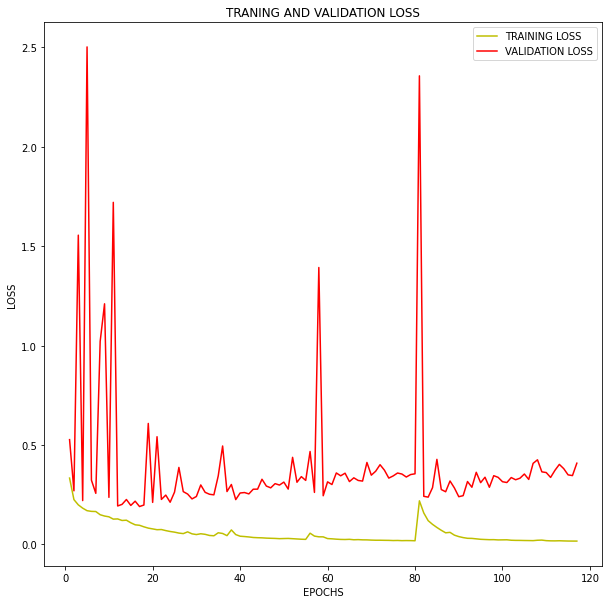

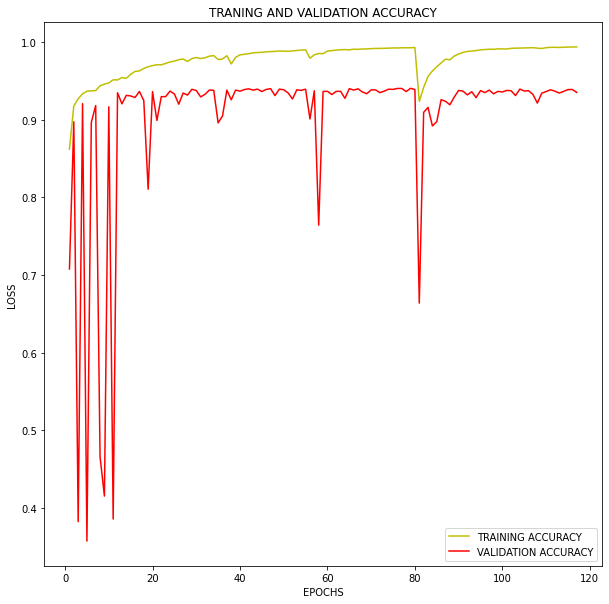

In [ ]:
# PLOTTING THE TRAINING AND VALIDATION LOSS OF THE MODEL
from matplotlib import pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label = 'TRAINING LOSS')
plt.plot(epochs, val_loss, 'r', label = 'VALIDATION LOSS')
plt.title('TRANING AND VALIDATION LOSS')
plt.xlabel('EPOCHS')
plt.ylabel('LOSS')
plt.legend()
plt.show()

# PLOTTING THE TRAINING AND VALIDATION ACCURACY OF THE MODEL
accuracy = history.history['acc']
validation_accuracy = history.history['val_acc']
epochs_2 = range(1, len(accuracy) + 1)
plt.plot(epochs_2, accuracy, 'y', label = 'TRAINING ACCURACY')
plt.plot(epochs_2, validation_accuracy, 'r', label = 'VALIDATION ACCURACY')
plt.title('TRANING AND VALIDATION ACCURACY')
plt.xlabel('EPOCHS')
plt.ylabel('LOSS')
plt.legend()
plt.show()

# PREDICTION ON TRAINING, VALIDATION AND TEST SET USING THE TRAINED WEIGHTS

In [ ]:
fcn_sar.load_weights("/content/drive/MyDrive/MASTER_RESEARCH/MODEL_TESTING/2_DEFORESTATION/AKHIL_MODEL/CLOUD_FREE_DATASET/TRAINED_MODEL/2020/LATE_FUSION/LF_2020_SEGNET_Weights_Improvement_79_0.94.hdf5")

In [ ]:
# EVALUATING THE MODEL PERFORMANCE ON TRAINING SET
res = fcn_sar.evaluate([x_train_S2, x_train_S1], y_train_S2)
print('________________________')
print('OVERALL ACCURACY:       |   {:.2f}  |'.format(res[1]*100))
print('F1 SCORE:               |   {:.2f}  |'.format(res[2]*100))
print('PRECISION:              |   {:.2f}  |'.format(res[3]*100))
print('RECALL:                 |   {:.2f}  |'.format(res[4]*100))
print('________________________')

45/45 [==============================] - 36s 446ms/step - loss: 0.0173 - acc: 0.9926 - f1_m: 0.9926 - precision_m: 0.9926 - recall_m: 0.9926
________________________
OVERALL ACCURACY:       |   99.26  |
F1 SCORE:               |   99.26  |
PRECISION:              |   99.26  |
RECALL:                 |   99.26  |
________________________


In [ ]:
# EVALUATING THE MODEL PERFORMANCE ON VALIDATION SET
res_2 = fcn_sar.evaluate([x_val_S2, x_val_S1], y_val_S2)
print('________________________')
print('OVERALL ACCURACY:       |   {:.2f}  |'.format(res_2[1]*100))
print('F1 SCORE:               |   {:.2f}  |'.format(res_2[2]*100))
print('PRECISION:              |   {:.2f}  |'.format(res_2[3]*100))
print('RECALL:                 |   {:.2f}  |'.format(res_2[4]*100))
print('________________________')

8/8 [==============================] - 3s 399ms/step - loss: 0.3508 - acc: 0.9401 - f1_m: 0.9401 - precision_m: 0.9401 - recall_m: 0.9401
________________________
OVERALL ACCURACY:       |   94.01  |
F1 SCORE:               |   94.01  |
PRECISION:              |   94.01  |
RECALL:                 |   94.01  |
________________________


In [ ]:
# # EVALUATING THE MODEL PERFORMANCE ON TEST SET 
# res_3 = fcn_sar.evaluate([x_test_S2, x_test_S1], y_test_GT)
# print('________________________')
# print('OVERALL ACCURACY:       |   {:.2f}  |'.format(res_3[1]*100))
# print('F1 SCORE:               |   {:.2f}  |'.format(res_3[2]*100))
# print('PRECISION:              |   {:.2f}  |'.format(res_3[3]*100))
# print('RECALL:                 |   {:.2f}  |'.format(res_3[4]*100))
# print('________________________')

In [36]:
# DEFINING A FUNCTION TO PERFORM PREDICTION ON TEST SET
def evaluate_predictions(Xtest, w8fname, cut, overlap, Ytest, model_builder):
    Ytest = Ytest.copy()
    Ytest[Ytest!=2] = 0
    Ytest[Ytest==2] = 1
    ncols, nrows, nbands2 = Xtest[0].shape
    ncols, nrows, nbands1 = Xtest[1].shape
    Xtest[0] = np.expand_dims(Xtest[0], axis=0)
    Xtest[1] = np.expand_dims(Xtest[1], axis=0)    
    total_map = np.zeros((nrows, ncols), dtype=np.uint8)
    first = True
    last = False
    if nrows%cut==0:
        numstrips = int(nrows/cut)
    else:
        numstrips = int(nrows/cut) + 1
    for i in range(numstrips):
        print("Strip number: %d" % i)
        if first:
            striptop = 0
            stripbottom = overlap
            height = cut
            X_sub2 = Xtest[0][:, cut*i-striptop:(cut*i)+height+stripbottom, :, :]
            X_sub1 = Xtest[1][:, cut*i-striptop:(cut*i)+height+stripbottom, :, :]
            first = False
        elif (not first) and (cut*(i+1)+1+overlap < nrows):
            striptop = overlap
            stripbottom = overlap
            height = cut
            X_sub2 = Xtest[0][:, cut*i-striptop:(cut*i)+height+stripbottom, :, :]
            X_sub1 = Xtest[1][:, cut*i-striptop:(cut*i)+height+stripbottom, :, :]
        else:
            print("Last hit!")
            striptop = overlap
            stripbottom = 0
            height = nrows - cut*i
            if (striptop+height)%(4)!=0:
                height = height*4
            X_sub2 = Xtest[0][:, -(striptop+height):, :, :]
            X_sub1 = Xtest[1][:, -(striptop+height):, :, :]
            last = True        
        sub_nrows = X_sub1.shape[1]
        sub_ncols = X_sub1.shape[2]
        model = model_builder(opt, sub_nrows, sub_ncols, [nbands2,nbands1], number_classes)
        model.load_weights(w8fname)
        sub_ns, sub_nb, _, __ = X_sub1.shape
        cmap = model.predict_on_batch([X_sub2,X_sub1])
        cmap = np.argmax(cmap[0], axis=2)
        if not last:
            total_map[cut*i:cut*i+height, :] = cmap[striptop:striptop+height, 0:total_map.shape[1]]
        else:
            total_map[-(height):, :] = cmap[-(height):, 0:total_map.shape[1]]
    return total_map

In [37]:
# IMAGES TILES FROM FULL RASTER
full_xtest_S1 = image_tiles_full_S1["ter"]
full_xtest_S2 = image_tiles_full_S2["ter"]
full_ytest = label_tiles_full["ter"]

# TRANSFORMATIONS AND PROJECTIONS OF THE INPUT RASTER

In [38]:
# PUTTING THE TRANSFORMATION AND PROJECTION OF THE INPUT RASTER WITHIN VARIABLE FOR SENTINEL-1
ds = gdal.Open("/content/drive/MyDrive/MASTER_RESEARCH/MODEL_TESTING/2_DEFORESTATION/AKHIL_MODEL/CLOUDY_DATASET/SENTINEL2/2020/20201025/IMAGE_FULL/raster.tif")
gt = ds.GetGeoTransform()
proj = ds.GetProjection()

In [39]:
import string
from matplotlib import colors
from sklearn.metrics import f1_score, precision_score, recall_score

# SET COLOUR CODES OF THE CLASSES
deforestation = [253, 231, 36]
non_deforestation = [32, 144, 140]
ccolors = (deforestation, non_deforestation)
NROWS, NCOLS, NBANDS2 = full_xtest_S2.shape
NROWS, NCOLS, NBANDS1 = full_xtest_S1.shape

"""
    Print the classified map.
    Keyword arguments:
    predictions -- the array output labels from the classification
    results
    idxarray -- the array of indices of the classified samples
    to be plotted.
    filename -- the name (with the directory) of the file where to
    write the map.
    ccolors -- an array of tuples containing rgb values for the classes
    Both arrays should match and be arranged accordingly. And the
    index of the color should match the value of the of prediction.
"""

def print_map(predictions, idxarray, filename = None, title = None, ccolors = None):
    if predictions.size != idxarray.shape[0]:
        raise ValueError("There should be the same number of " +
                         "predictions and indices.")
    nrows, ncols = np.max(idxarray[:, 0])+1, np.max(idxarray[:, 1])+1
    classifiedmap = np.zeros((nrows, ncols, 3), dtype="uint8")
    idx = 0
    for prediction in predictions:
        classifiedmap[idxarray[idx, 0],
                      idxarray[idx, 1]] = np.asarray(ccolors[prediction])
        idx += 1
    if filename is None:
        fig = plt.figure()
        plt.imshow(classifiedmap)
        if title:
            plt.suptitle(title)
        plt.show()
    else:
        output_raster = gdal.GetDriverByName('GTiff').Create(filename, NCOLS, NROWS, number_classes, gdal.GDT_Byte)
        output_raster.SetGeoTransform(gt)
        output_raster.SetProjection(proj)
        
        for i in range(number_classes):
            output_raster.GetRasterBand(i+1).WriteArray(classifiedmap.astype(np.uint8)[:, :, i])

In [40]:
"""Compute the Confusion Matrix

    Keyword arguments:
    prediction -- the array output labels from the classification
    results
    labels -- the  array of "true" labels from the test set
    Both arrays should match, be arranged accordingly, and
    have non-negative values.
"""

def get_confusion_matrix(predictions, labels):
    classes = np.unique(labels)
    nbclasses = classes.size
    if labels.size != predictions.size:
        raise ValueError("There should be the same number of " +
                         "predictions and labels.")
    merged = np.concatenate((predictions.reshape(predictions.size, 1),
                             labels.reshape(labels.size, 1)), axis=1)
    CM = np.zeros((classes[-1] + 1, classes[-1] + 1))
    for c1 in classes:
        for c2 in classes:
            CM[c1, c2] = np.sum(np.logical_and(merged[:, 1] == c1,
                                               merged[:, 0] == c2))
    return CM

In [41]:
"""Utility function to create cartesian image coordinates."""

def cartesian(arrays, out=None):
    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype
    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)
    m = int(n / arrays[0].size)
    out[:, 0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m, 1:])
        for j in range(1, arrays[0].size):
            out[j*m:(j+1)*m, 1:] = out[0:m, 1:]
    return out

In [42]:
cut = 256
overlap = 0
weights_pretrained_FCN = "/content/drive/MyDrive/MASTER_RESEARCH/MODEL_TESTING/2_DEFORESTATION/AKHIL_MODEL/CLOUD_FREE_DATASET/TRAINED_MODEL/2020/LATE_FUSION/LF_2020_SEGNET_Weights_Improvement_79_0.94.hdf5"
predictions_FCN = evaluate_predictions([full_xtest_S2, full_xtest_S1], weights_pretrained_FCN, cut, overlap, full_ytest, late_fusion_model)

Strip number: 0
Strip number: 1
Strip number: 2
Strip number: 3
Strip number: 4
Strip number: 5
Strip number: 6
Strip number: 7
Strip number: 8
Strip number: 9
Strip number: 10
Strip number: 11
Strip number: 12
Strip number: 13
Strip number: 14
Strip number: 15
Strip number: 16
Strip number: 17
Strip number: 18
Strip number: 19
Strip number: 20
Strip number: 21
Strip number: 22
Strip number: 23
Strip number: 24
Strip number: 25
Strip number: 26
Strip number: 27
Strip number: 28
Strip number: 29
Strip number: 30
Strip number: 31
Strip number: 32
Strip number: 33
Strip number: 34
Strip number: 35
Strip number: 36
Strip number: 37
Strip number: 38
Strip number: 39
Strip number: 40
Strip number: 41
Strip number: 42
Strip number: 43
Last hit!


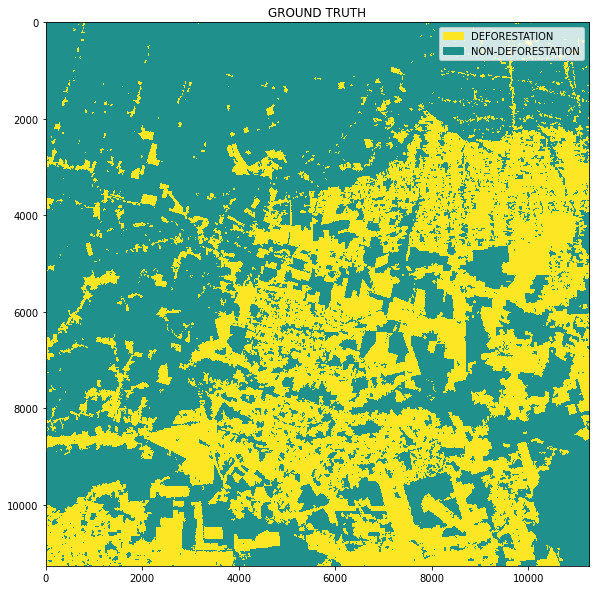

In [43]:
# PLOT REFERENCE MAP
norm_ccolors = np.array(ccolors)/255.0
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1)
cmap = colors.ListedColormap(norm_ccolors)
bounds = [0,1,2]
norm = colors.BoundaryNorm(bounds, cmap.N)
labels = full_ytest[:, :, 0].copy()
labels[labels!=2] = 0
labels[labels==2] = 1
ax.imshow(labels, cmap = cmap, norm=norm, interpolation = "nearest", origin = "upper")
ax.set_title("GROUND TRUTH")
rectangles = [matplotlib.patches.Rectangle((0, 0), 1, 1, color=norm_ccolors[r]) for r in range(norm_ccolors.shape[0])]
classes = ["DEFORESTATION", "NON-DEFORESTATION"]
#Create legend from custom artist/label lists
ax.legend(rectangles, classes)
plt.show()
labels = labels.astype("uint8")

ACCURACY METRICS OF SEGNET RESULTS:

Overall Accuracy: 0.969381
F1 SCORE: 0.973018
PA of Deforestation: 0.966946
PA of Non-Deforestation: 0.970926
User Accuracy of Deforestation: 0.966946
User Accuracy of Non-Deforestation: 0.970926
Producer Accuracy of Deforestation: 0.954752
Producer Accuracy of Non-Deforestation: 0.978858


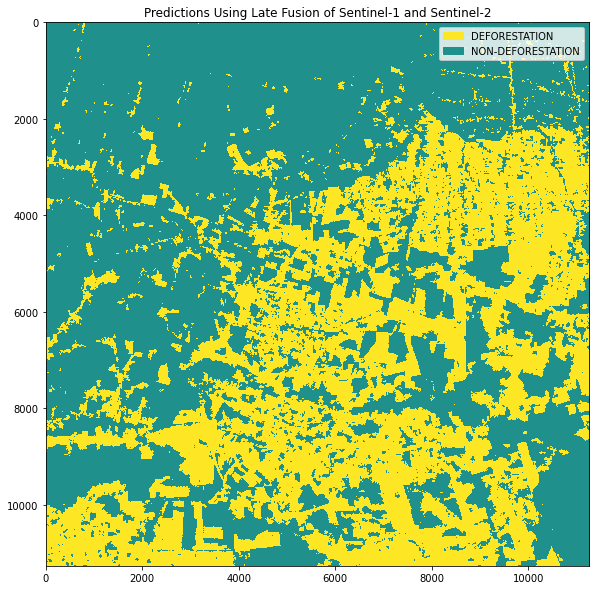

In [44]:
# EVALUATE SEGNET BASED LATE FUSION
predictions = predictions_FCN
mapidx = cartesian([range(predictions.shape[0]), range(predictions.shape[1])])
CM = get_confusion_matrix(predictions, labels)
OA = np.sum(np.diag(CM))/predictions.size
PA_bldg = ((predictions[labels==0]==labels[labels==0]).sum())/(labels[labels==0].size)
PA_rd = ((predictions[labels==1]==labels[labels==1]).sum())/(labels[labels==1].size)

# CALCULATION OF USER ACCURACY FOR DEFORESTATION
a = CM[0][0]
b = CM[0][1]
ua_deforestation = a/(a+b)
c = CM[1][0]
d = CM[1][1]
ua_non_deforest = d/(c+d)

# CALCULATION OF PRODUCER ACCURACY FOR DEFORESTATION
e = CM[0][0]
f = CM[1][0]
pa_deforestation = e/(e+f)
g = CM[0][1]
h = CM[1][1]
pa_non_deforest = h/(g+h)

print("ACCURACY METRICS OF SEGNET RESULTS:\n")
print("Overall Accuracy: %f" % OA)
print("F1 SCORE: %f" %(f1_score(labels, predictions, average="macro")))
print("PA of Deforestation: %f" % PA_bldg)
print("PA of Non-Deforestation: %f" % PA_rd)

print("User Accuracy of Deforestation: %f" % ua_deforestation)
print("User Accuracy of Non-Deforestation: %f" % ua_non_deforest)
print("Producer Accuracy of Deforestation: %f" % pa_deforestation)
print("Producer Accuracy of Non-Deforestation: %f" % pa_non_deforest)

mapfname = "/content/drive/MyDrive/MASTER_RESEARCH/MODEL_TESTING/2_DEFORESTATION/AKHIL_MODEL/OUTPUT_TIFF/CLOUD_FREE/2020/FUSION_FULL_IMAGE.tif"

predictions_ = predictions.flatten()
print_map(predictions_, mapidx, ccolors = ccolors, filename = mapfname)
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(predictions, cmap = cmap, norm = norm, interpolation = "nearest", origin = "upper")
ax.set_title("Predictions Using Late Fusion of Sentinel-1 and Sentinel-2")

# Code for Printing the Labels
rectangles = [matplotlib.patches.Rectangle((0, 0), 1, 1, color = norm_ccolors[r]) for r in range(norm_ccolors.shape[0])]
classes = ["DEFORESTATION", "NON-DEFORESTATION"]
ax.legend(rectangles, classes)

plt.show()

In [45]:
# PUTTING ALL THE TRUE AND FALSE VALUES INSIDE A "CSV" FILE
import pandas as pd
predictions_2 = predictions.ravel()
labels_2 = labels.ravel()
sentinel2_full = (predictions_2 == labels_2)
sentinel2_full_2 = pd.Series(sentinel2_full)
sentinel2_full_3 = pd.DataFrame(sentinel2_full_2)
sentinel2_full_4 = sentinel2_full_3.rename(columns = {0:'LATE_FUSION'})
sentinel2_full_4

,LATE_FUSION
0,True
1,True
2,True
3,True
4,True
...,...
126877691,True
126877692,True
126877693,True
126877694,True


In [46]:
sentinel2_full_4.to_csv("/content/drive/MyDrive/MASTER_RESEARCH/MODEL_TESTING/2_DEFORESTATION/AKHIL_MODEL/MCNEMAR_TEST/CLOUD_FREE/LATE_FUSION/FULL_IMAGE.csv")

In [47]:
# IMPORT THE ESSENTIAL LIBRARIES FOR PLOTTING TE CONFUSION MATRIX
import seaborn as sns
import matplotlib.pyplot as plt

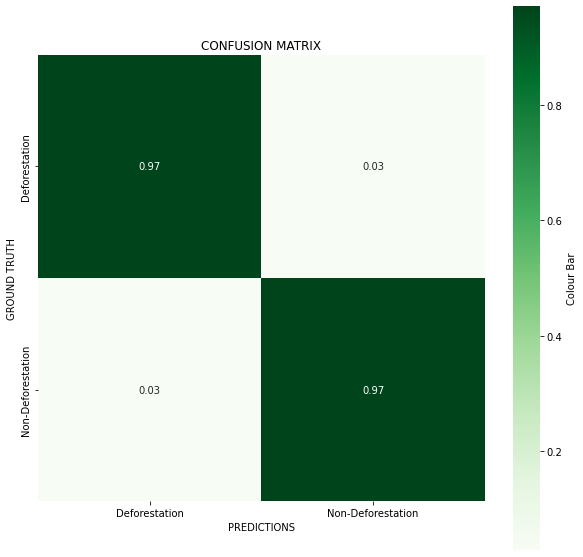

In [48]:
# print("NORMALIZED CONFUSION MATRIX:")
cm_normalized = np.round(CM/np.sum(CM, axis = 1).reshape(-1, 1), 2)
# print(cm_normalized)
sns.heatmap(cm_normalized, cmap = "Greens", annot = True, 
            cbar_kws = {"orientation":"vertical", "label":"Colour Bar"},
            xticklabels = ["Deforestation", "Non-Deforestation"], yticklabels = ["Deforestation", "Non-Deforestation"], square = True)
sns.set(rc = {'figure.figsize':(8, 8)})
plt.xlabel("PREDICTIONS")
plt.ylabel("GROUND TRUTH")
plt.title("CONFUSION MATRIX")
plt.show()

# TEST SET 1

In [49]:
# IMAGES TILES FROM FULL RASTER
x_test_S1_1 = image_tiles_S1_16_grid["_12"]
x_test_S2_1 = image_tiles_S2_16_grid["_12"]
y_test_1 = label_tiles_16_grid["_12"]

In [50]:
# PUTTING THE TRANSFORMATION AND PROJECTION OF THE INPUT RASTER WITHIN VARIABLE FOR SENTINEL-1
ds_2 = gdal.Open("/content/drive/MyDrive/MASTER_RESEARCH/MODEL_TESTING/2_DEFORESTATION/AKHIL_MODEL/CLOUD_FREE_DATASET/2020/SENTINEL2/IMAGE_16_GRID/RASTER_12.tif")
gt_2 = ds_2.GetGeoTransform()
proj_2 = ds_2.GetProjection()

In [51]:
import string
from matplotlib import colors
from sklearn.metrics import f1_score, precision_score, recall_score

# SET COLOUR CODES OF THE CLASSES
deforestation = [253, 231, 36]
non_deforestation = [32, 144, 140]
ccolors = (deforestation, non_deforestation)
NROWS, NCOLS, NBANDS2 = x_test_S2_1.shape
NROWS, NCOLS, NBANDS1 = x_test_S1_1.shape

"""
    Print the classified map.
    Keyword arguments:
    predictions -- the array output labels from the classification
    results
    idxarray -- the array of indices of the classified samples
    to be plotted.
    filename -- the name (with the directory) of the file where to
    write the map.
    ccolors -- an array of tuples containing rgb values for the classes
    Both arrays should match and be arranged accordingly. And the
    index of the color should match the value of the of prediction.
"""

def print_map_2(predictions, idxarray, filename = None, title = None, ccolors = None):
    if predictions.size != idxarray.shape[0]:
        raise ValueError("There should be the same number of " +
                         "predictions and indices.")
    nrows, ncols = np.max(idxarray[:, 0])+1, np.max(idxarray[:, 1])+1
    classifiedmap = np.zeros((nrows, ncols, 3), dtype="uint8")
    idx = 0
    for prediction in predictions:
        classifiedmap[idxarray[idx, 0],
                      idxarray[idx, 1]] = np.asarray(ccolors[prediction])
        idx += 1
    if filename is None:
        fig = plt.figure()
        plt.imshow(classifiedmap)
        if title:
            plt.suptitle(title)
        plt.show()
    else:
        output_raster = gdal.GetDriverByName('GTiff').Create(filename, NCOLS, NROWS, number_classes, gdal.GDT_Byte)
        output_raster.SetGeoTransform(gt_2)
        output_raster.SetProjection(proj_2)
        
        for i in range(number_classes):
            output_raster.GetRasterBand(i+1).WriteArray(classifiedmap.astype(np.uint8)[:, :, i])

In [52]:
predictions_FCN = evaluate_predictions([x_test_S2_1, x_test_S1_1], weights_pretrained_FCN, cut, overlap, y_test_1, late_fusion_model)

Strip number: 0
Strip number: 1
Strip number: 2
Strip number: 3
Strip number: 4
Strip number: 5
Strip number: 6
Strip number: 7
Strip number: 8
Strip number: 9
Strip number: 10
Last hit!


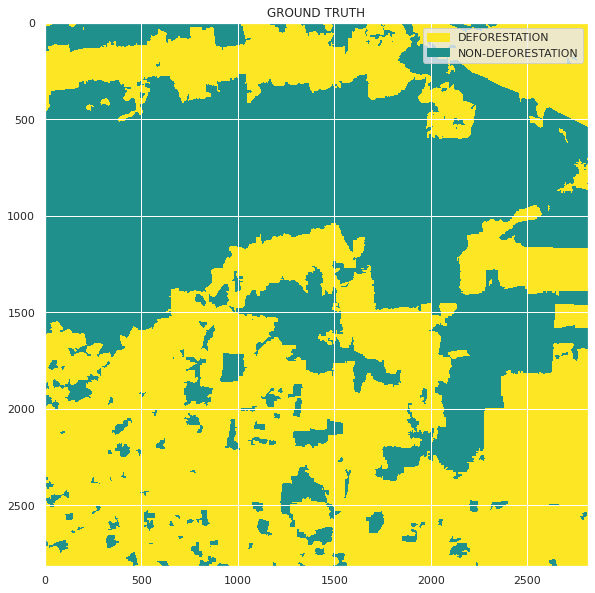

In [53]:
# PLOT REFERENCE MAP
norm_ccolors = np.array(ccolors)/255.0
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1)
cmap = colors.ListedColormap(norm_ccolors)
bounds = [0, 1, 2]
norm = colors.BoundaryNorm(bounds, cmap.N)
labels = y_test_1[:, :, 0].copy()
labels[labels!=2] = 0
labels[labels==2] = 1
ax.imshow(labels, cmap = cmap, norm=norm, interpolation = "nearest", origin = "upper")
ax.set_title("GROUND TRUTH")
rectangles = [matplotlib.patches.Rectangle((0, 0), 1, 1, color=norm_ccolors[r]) for r in range(norm_ccolors.shape[0])]
classes = ["DEFORESTATION", "NON-DEFORESTATION"]
#Create legend from custom artist/label lists
ax.legend(rectangles, classes)
plt.show()
labels = labels.astype("uint8")

ACCURACY METRICS OF SEGNET RESULTS:

Overall Accuracy: 0.942933
F1 SCORE: 0.937349
PA of Deforestation: 0.953874
PA of Non-Deforestation: 0.930540
User Accuracy of Deforestation: 0.953874
User Accuracy of Non-Deforestation: 0.930540
Producer Accuracy of Deforestation: 0.939591
Producer Accuracy of Non-Deforestation: 0.946842


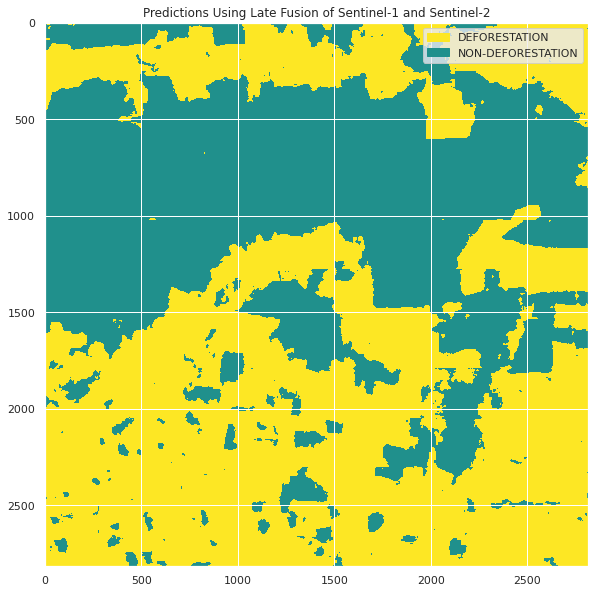

In [54]:
# EVALUATE SEGNET BASED LATE FUSION
predictions = predictions_FCN
mapidx = cartesian([range(predictions.shape[0]), range(predictions.shape[1])])
CM = get_confusion_matrix(predictions, labels)
OA = np.sum(np.diag(CM))/predictions.size
PA_bldg = ((predictions[labels==0]==labels[labels==0]).sum())/(labels[labels==0].size)
PA_rd = ((predictions[labels==1]==labels[labels==1]).sum())/(labels[labels==1].size)

# CALCULATION OF USER ACCURACY FOR DEFORESTATION
a = CM[0][0]
b = CM[0][1]
ua_deforestation = a/(a+b)
c = CM[1][0]
d = CM[1][1]
ua_non_deforest = d/(c+d)

# CALCULATION OF PRODUCER ACCURACY FOR DEFORESTATION
e = CM[0][0]
f = CM[1][0]
pa_deforestation = e/(e+f)
g = CM[0][1]
h = CM[1][1]
pa_non_deforest = h/(g+h)

print("ACCURACY METRICS OF SEGNET RESULTS:\n")
print("Overall Accuracy: %f" % OA)
print("F1 SCORE: %f" %(f1_score(labels, predictions, average="macro")))
print("PA of Deforestation: %f" % PA_bldg)
print("PA of Non-Deforestation: %f" % PA_rd)

print("User Accuracy of Deforestation: %f" % ua_deforestation)
print("User Accuracy of Non-Deforestation: %f" % ua_non_deforest)
print("Producer Accuracy of Deforestation: %f" % pa_deforestation)
print("Producer Accuracy of Non-Deforestation: %f" % pa_non_deforest)

mapfname = "/content/drive/MyDrive/MASTER_RESEARCH/MODEL_TESTING/2_DEFORESTATION/AKHIL_MODEL/OUTPUT_TIFF/CLOUD_FREE/2020/FUSION_TEST1.tif"

predictions_ = predictions.flatten()
print_map_2(predictions_, mapidx, ccolors = ccolors, filename = mapfname)
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(predictions, cmap = cmap, norm = norm, interpolation = "nearest", origin = "upper")
ax.set_title("Predictions Using Late Fusion of Sentinel-1 and Sentinel-2")

# Code for Printing the Labels
rectangles = [matplotlib.patches.Rectangle((0, 0), 1, 1, color = norm_ccolors[r]) for r in range(norm_ccolors.shape[0])]
classes = ["DEFORESTATION", "NON-DEFORESTATION"]
ax.legend(rectangles, classes)

plt.show()

In [55]:
# PUTTING ALL THE TRUE AND FALSE VALUES INSIDE A "CSV" FILE
import pandas as pd
predictions_2 = predictions.ravel()
labels_2 = labels.ravel()
sentinel2_full = (predictions_2 == labels_2)
sentinel2_full_2 = pd.Series(sentinel2_full)
sentinel2_full_3 = pd.DataFrame(sentinel2_full_2)
sentinel2_full_4 = sentinel2_full_3.rename(columns = {0:'LATE_FUSION'})
sentinel2_full_4

,LATE_FUSION
0,True
1,True
2,True
3,True
4,True
...,...
7929851,True
7929852,True
7929853,True
7929854,True


In [56]:
sentinel2_full_4.to_csv("/content/drive/MyDrive/MASTER_RESEARCH/MODEL_TESTING/2_DEFORESTATION/AKHIL_MODEL/MCNEMAR_TEST/CLOUD_FREE/LATE_FUSION/TEST1.csv")

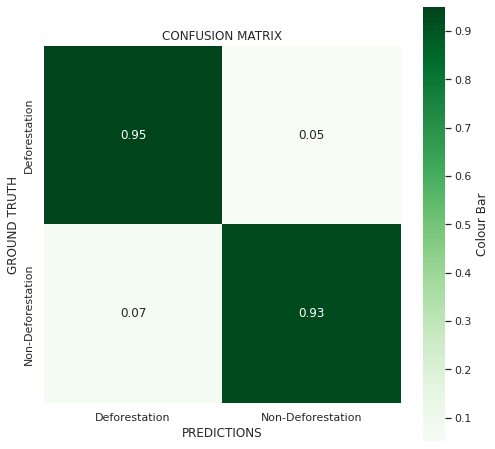

In [57]:
# print("NORMALIZED CONFUSION MATRIX:")
cm_normalized = np.round(CM/np.sum(CM, axis = 1).reshape(-1, 1), 2)
# print(cm_normalized)
sns.heatmap(cm_normalized, cmap = "Greens", annot = True, 
            cbar_kws = {"orientation":"vertical", "label":"Colour Bar"},
            xticklabels = ["Deforestation", "Non-Deforestation"], yticklabels = ["Deforestation", "Non-Deforestation"], square = True)
sns.set(rc = {'figure.figsize':(8, 8)})
plt.xlabel("PREDICTIONS")
plt.ylabel("GROUND TRUTH")
plt.title("CONFUSION MATRIX")
plt.show()

# TEST SET 2

In [58]:
# IMAGES TILES FROM FULL RASTER
x_test_S1_2 = image_tiles_S1_16_grid["_14"]
x_test_S2_2 = image_tiles_S2_16_grid["_14"]
y_test_2 = label_tiles_16_grid["_14"]

In [59]:
# PUTTING THE TRANSFORMATION AND PROJECTION OF THE INPUT RASTER WITHIN VARIABLE FOR SENTINEL-1
ds_3 = gdal.Open("/content/drive/MyDrive/MASTER_RESEARCH/MODEL_TESTING/2_DEFORESTATION/AKHIL_MODEL/CLOUD_FREE_DATASET/2020/SENTINEL2/IMAGE_16_GRID/RASTER_14.tif")
gt_3 = ds_3.GetGeoTransform()
proj_3 = ds_3.GetProjection()

In [60]:
import string
from matplotlib import colors
from sklearn.metrics import f1_score, precision_score, recall_score

# SET COLOUR CODES OF THE CLASSES
deforestation = [253, 231, 36]
non_deforestation = [32, 144, 140]
ccolors = (deforestation, non_deforestation)
NROWS, NCOLS, NBANDS2 = x_test_S2_2.shape
NROWS, NCOLS, NBANDS1 = x_test_S1_2.shape

"""
    Print the classified map.
    Keyword arguments:
    predictions -- the array output labels from the classification
    results
    idxarray -- the array of indices of the classified samples
    to be plotted.
    filename -- the name (with the directory) of the file where to
    write the map.
    ccolors -- an array of tuples containing rgb values for the classes
    Both arrays should match and be arranged accordingly. And the
    index of the color should match the value of the of prediction.
"""

def print_map_3(predictions, idxarray, filename = None, title = None, ccolors = None):
    if predictions.size != idxarray.shape[0]:
        raise ValueError("There should be the same number of " +
                         "predictions and indices.")
    nrows, ncols = np.max(idxarray[:, 0])+1, np.max(idxarray[:, 1])+1
    classifiedmap = np.zeros((nrows, ncols, 3), dtype="uint8")
    idx = 0
    for prediction in predictions:
        classifiedmap[idxarray[idx, 0],
                      idxarray[idx, 1]] = np.asarray(ccolors[prediction])
        idx += 1
    if filename is None:
        fig = plt.figure()
        plt.imshow(classifiedmap)
        if title:
            plt.suptitle(title)
        plt.show()
    else:
        output_raster = gdal.GetDriverByName('GTiff').Create(filename, NCOLS, NROWS, number_classes, gdal.GDT_Byte)
        output_raster.SetGeoTransform(gt_3)
        output_raster.SetProjection(proj_3)

        for i in range(number_classes):
            output_raster.GetRasterBand(i+1).WriteArray(classifiedmap.astype(np.uint8)[:, :, i])

In [61]:
predictions_FCN = evaluate_predictions([x_test_S2_2, x_test_S1_2], weights_pretrained_FCN, cut, overlap, y_test_2, late_fusion_model)

Strip number: 0
Strip number: 1
Strip number: 2
Strip number: 3
Strip number: 4
Strip number: 5
Strip number: 6
Strip number: 7
Strip number: 8
Strip number: 9
Strip number: 10
Last hit!


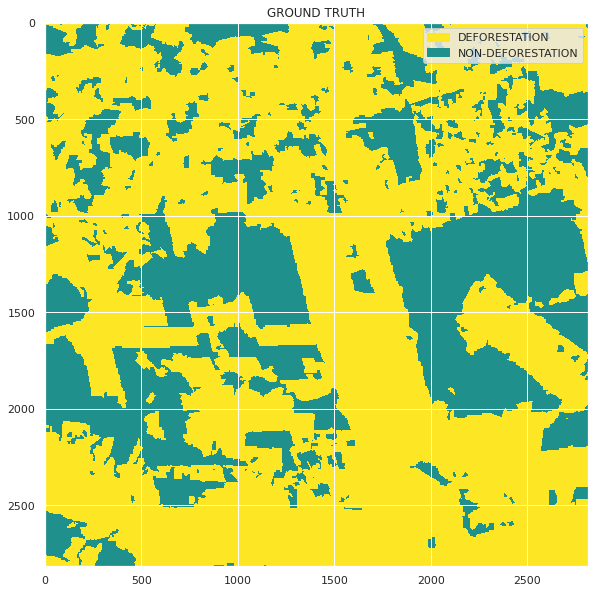

In [62]:
# PLOT REFERENCE MAP
norm_ccolors = np.array(ccolors)/255.0
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1)
cmap = colors.ListedColormap(norm_ccolors)
bounds = [0,1,2]
norm = colors.BoundaryNorm(bounds, cmap.N)
labels = y_test_2[:, :, 0].copy()
labels[labels!=2] = 0
labels[labels==2] = 1
ax.imshow(labels, cmap = cmap, norm=norm, interpolation = "nearest", origin = "upper")
ax.set_title("GROUND TRUTH")
rectangles = [matplotlib.patches.Rectangle((0, 0), 1, 1, color=norm_ccolors[r]) for r in range(norm_ccolors.shape[0])]
classes = ["DEFORESTATION", "NON-DEFORESTATION"]
#Create legend from custom artist/label lists
ax.legend(rectangles, classes)
plt.show()
labels = labels.astype("uint8")

ACCURACY METRICS OF SEGNET RESULTS:

Overall Accuracy: 0.911120
F1 SCORE: 0.816247
PA of Deforestation: 0.968924
PA of Non-Deforestation: 0.789633
User Accuracy of Deforestation: 0.968924
User Accuracy of Non-Deforestation: 0.789633
Producer Accuracy of Deforestation: 0.906368
Producer Accuracy of Non-Deforestation: 0.923607


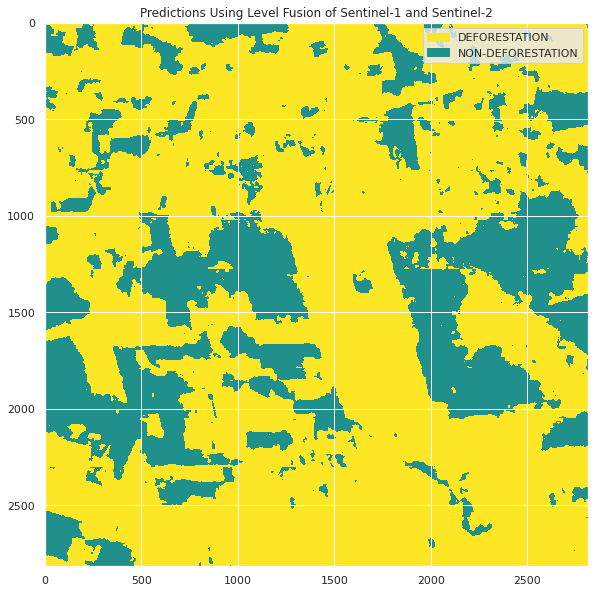

In [63]:
# EVALUATE SEGNET BASED LATE FUSION
predictions = predictions_FCN
mapidx = cartesian([range(predictions.shape[0]), range(predictions.shape[1])])
CM = get_confusion_matrix(predictions, labels)
OA = np.sum(np.diag(CM))/predictions.size
PA_bldg = ((predictions[labels==0]==labels[labels==0]).sum())/(labels[labels==0].size)
PA_rd = ((predictions[labels==1]==labels[labels==1]).sum())/(labels[labels==1].size)

# CALCULATION OF USER ACCURACY FOR DEFORESTATION
a = CM[0][0]
b = CM[0][1]
ua_deforestation = a/(a+b)
c = CM[1][0]
d = CM[1][1]
ua_non_deforest = d/(c+d)

# CALCULATION OF PRODUCER ACCURACY FOR DEFORESTATION
e = CM[0][0]
f = CM[1][0]
pa_deforestation = e/(e+f)
g = CM[0][1]
h = CM[1][1]
pa_non_deforest = h/(g+h)

print("ACCURACY METRICS OF SEGNET RESULTS:\n")
print("Overall Accuracy: %f" % OA)
print("F1 SCORE: %f" %(f1_score(labels, predictions, average="macro")))
print("PA of Deforestation: %f" % PA_bldg)
print("PA of Non-Deforestation: %f" % PA_rd)

print("User Accuracy of Deforestation: %f" % ua_deforestation)
print("User Accuracy of Non-Deforestation: %f" % ua_non_deforest)
print("Producer Accuracy of Deforestation: %f" % pa_deforestation)
print("Producer Accuracy of Non-Deforestation: %f" % pa_non_deforest)

mapfname = "/content/drive/MyDrive/MASTER_RESEARCH/MODEL_TESTING/2_DEFORESTATION/AKHIL_MODEL/OUTPUT_TIFF/CLOUD_FREE/2020/FUSION_TEST2.tif"

predictions_ = predictions.flatten()
print_map_3(predictions_, mapidx, ccolors = ccolors, filename = mapfname)
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(predictions, cmap = cmap, norm = norm, interpolation = "nearest", origin = "upper")
ax.set_title("Predictions Using Level Fusion of Sentinel-1 and Sentinel-2")

# Code for Printing the Labels
rectangles = [matplotlib.patches.Rectangle((0, 0), 1, 1, color = norm_ccolors[r]) for r in range(norm_ccolors.shape[0])]
classes = ["DEFORESTATION", "NON-DEFORESTATION"]
ax.legend(rectangles, classes)

plt.show()

In [64]:
# PUTTING ALL THE TRUE AND FALSE VALUES INSIDE A "CSV" FILE
import pandas as pd
predictions_2 = predictions.ravel()
labels_2 = labels.ravel()
sentinel2_full = (predictions_2 == labels_2)
sentinel2_full_2 = pd.Series(sentinel2_full)
sentinel2_full_3 = pd.DataFrame(sentinel2_full_2)
sentinel2_full_4 = sentinel2_full_3.rename(columns = {0:'LATE_FUSION'})
sentinel2_full_4

,LATE_FUSION
0,False
1,False
2,True
3,True
4,True
...,...
7929851,True
7929852,True
7929853,True
7929854,True


In [65]:
sentinel2_full_4.to_csv("/content/drive/MyDrive/MASTER_RESEARCH/MODEL_TESTING/2_DEFORESTATION/AKHIL_MODEL/MCNEMAR_TEST/CLOUD_FREE/LATE_FUSION/TEST2.csv")

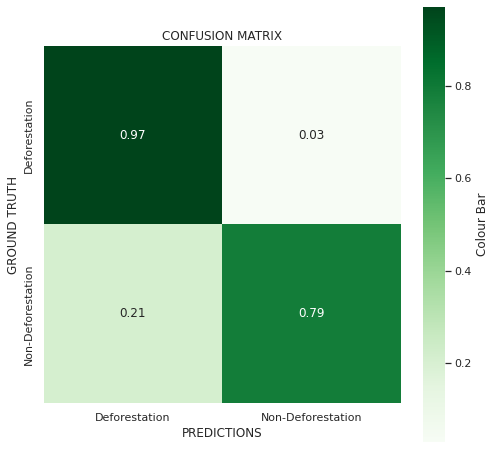

In [66]:
# print("NORMALIZED CONFUSION MATRIX:")
cm_normalized = np.round(CM/np.sum(CM, axis = 1).reshape(-1, 1), 2)
# print(cm_normalized)
sns.heatmap(cm_normalized, cmap = "Greens", annot = True, 
            cbar_kws = {"orientation":"vertical", "label":"Colour Bar"},
            xticklabels = ["Deforestation", "Non-Deforestation"], yticklabels = ["Deforestation", "Non-Deforestation"], square = True)
sns.set(rc = {'figure.figsize':(8, 8)})
plt.xlabel("PREDICTIONS")
plt.ylabel("GROUND TRUTH")
plt.title("CONFUSION MATRIX")
plt.show()